
# Практическое задание 4. Бустинг и бэггинг

## Общая информация
Дата выдачи: 14.01.2024

Мягкий дедлайн: 28.01.2024 23:59 MSK

Жёсткий дедлайн: 04.02.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. 

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Работать мы будем на двух наборах данных: многомерных данных по кредитам с kaggle и синтетических двумерных. В данных с kaggle целевая переменная показывает, вернуло ли кредит физическое лицо:

In [164]:
import numpy as np
import pandas as pd
import random
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, BaggingClassifier

from xgboost import XGBClassifier

In [2]:
# !wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [3]:
pd.set_option('display.max_columns', 99)

In [4]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

age           job  marital          education default housing loan  \
8515   45  entrepreneur  married  university.degree      no     yes  yes   
7077   39   blue-collar  married           basic.9y      no     yes   no   
334    68       retired  married  university.degree      no     yes   no   
424    26   blue-collar   single           basic.9y      no     yes   no   
3525   31    unemployed   single  university.degree      no     yes   no   

        contact month day_of_week  duration  campaign  pdays  previous  \
8515  telephone   may         fri       515         1    999         0   
7077   cellular   may         tue       323         1    999         0   
334    cellular   jul         mon       546         2    999         1   
424   telephone   may         fri       149         1    999         0   
3525   cellular   jul         tue       309         1      6         3   

         poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
8515  nonexistent           1.1          93.994          -36.4      4.859   
7077  nonexistent          -1.8          92.893          -46.2      1.266   
334       failure          -1.7          94.215          -40.3      0.889   
424   nonexistent           1.1          93.994          -36.4      4.864   
3525      success          -1.7          94.215          -40.3      0.835   

      nr.employed  y  
8515       5191.0  1  
7077       5099.1 -1  
334        4991.6  1  
424        5191.0 -1  
3525       4991.6  1

Разделим на train и test (random_state не меняем)

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Генерируем синтетические данные (seed не меняем)

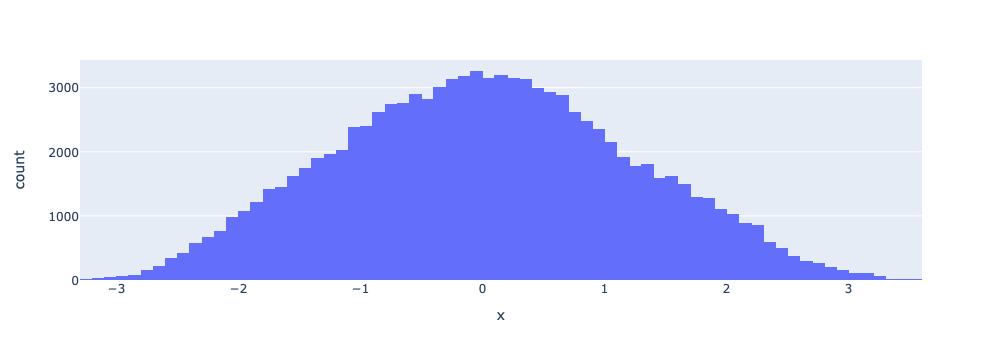

In [6]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [39]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''
    
    mask = np.random.choice([True, False], size=features.shape[0], 
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps
    
    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)
    
    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid).reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float64)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()
    
    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

#### 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации.

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже). Кроме того, нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [8]:
class Boosting:
    
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_depth': 5},
        n_estimators: int=10,
        learning_rate: float=0.1,
        use_gamma: bool=False,
        subsample: float=1,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None,
        show_process: bool=True
    ):
        
        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping

        self.show_process = show_process
        
        # Плейсхолдер для нулевой модели
        self.initial_model = None
        self.initial_model_pred = None
        
        # Список для хранения весов при моделях
        self.gammas = []
        
        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]

        # Выбираем лучшую модель
        self.best_model_index = None
        self.best_model_iter_eval_loss = None
        
        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

        # Флаги
        self._is_fitted = False
        self.use_gamma = use_gamma
            
        
    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        """
        # Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        np.random.seed(self.random_seed)
        random.seed(self.random_seed)
        total_obj = np.array(X).shape[0]
        n_subsample_objects = int(total_obj * self.subsample)
        idx = random.choices(range(total_obj), k=n_subsample_objects) 
        X_part = np.array(X)[idx]
        y_part = np.array(y)[idx]
        model_tmp = self.models[n_model]
        model_tmp.fit(X_part, y_part)

        return model_tmp
        
        
    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """
        np.random.seed(self.random_seed)
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        self.initial_model = DecisionTreeClassifier(max_depth=1)
        self.initial_model.fit(np.array(X), np.array(y))
        self.initial_model_pred = self.initial_model.predict_proba(np.array(X))[:, 0]
    
    
    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (после сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        np.random.seed(self.random_seed)
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss
        
        return optimal_gamma
        
        
    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """
        
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        self._fit_initial_model(X, y)
        residuals = list()
        residuals.append((self.sigmoid(np.array(y)) - self.initial_model_pred))

        if eval_set:
            X_val, y_val = eval_set
            eval_residuals = list()
            eval_initital_pred = self.initial_model.predict_proba(np.array(X_val))[:, 0]
            epsilon = 0.000001
            eval_residuals.append(self.sigmoid(np.array(y_val) + epsilon) - np.array(eval_initital_pred))
            self.best_model_iter_eval_loss = list()
            self.best_model_iter_eval_loss.append(self.loss_fn(y_val, eval_initital_pred + sum(np.array(eval_residuals))))
            if not self.n_iter_early_stopping:
                self.n_iter_early_stopping = 10

        for iter in range(len(self.models)):
            iter_model = self._fit_new_model(np.array(X), residuals[iter], iter)
            iter_pred = iter_model.predict(np.array(X))
            if self.use_gamma:
                if iter == 0:
                    gamma = self._find_optimal_gamma(
                        y=np.array(y),
                        old_predictions=self.initial_model_pred,
                        new_predictions=iter_pred
                        )
                else:
                     gamma = self._find_optimal_gamma(
                        y=np.array(y),
                        old_predictions=residuals[iter-1],
                        new_predictions=iter_pred
                        )
                iter_pred = gamma * iter_pred
            residuals.append(np.array(residuals[iter] - (self.learning_rate * iter_pred)))
            self.best_model_index = iter

            if eval_set:
                eval_pred_tmp = iter_model.predict(np.array(X_val))
                eval_residuals.append(np.array(eval_residuals[iter] - (self.learning_rate * eval_pred_tmp)))
                
                self.best_model_iter_eval_loss.append(self.loss_fn(y_val, eval_initital_pred + sum(np.array(eval_residuals))))
                
                if len(self.best_model_iter_eval_loss) > self.n_iter_early_stopping:
                    stop_index = iter + 1 - self.n_iter_early_stopping
                    stop_val = self.best_model_iter_eval_loss[stop_index]
                    tmp_flag_early_stop_lst = (np.array(self.best_model_iter_eval_loss[stop_index:(iter+1)]) < stop_val)

                    if sum(tmp_flag_early_stop_lst) == 0:
                        # self.best_model_index = iter + 1 - self.n_iter_early_stopping
                        self.best_model_index = iter - (self.n_iter_early_stopping - 1)
                        self._is_fitted = True
                        if self.show_process == True:
                            print(f'Early stopping is triggered! Best iter was: {self.best_model_index}')
                        return None
                    else:
                        self.best_model_index = iter
            
            if self.show_process == True:
                train_loss = self.loss_fn(y, self.initial_model_pred + sum(np.array(residuals)))
                if eval_set:
                    val_loss = self.best_model_iter_eval_loss[-1]
                    print(f'{iter}: train_loss = {train_loss} _ val_loss = {val_loss}')
                else:
                    print(f'{iter}: train_loss = {train_loss}')
            
        self._is_fitted = True
        
        return None
        
    
    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """
        
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        probas_preds = self.predict_proba(X)
        classes_preds = [1 if (x >= 0.5) else 0 for x in probas_preds]

        return np.array(classes_preds)
            
        
    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """
        
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        if not self._is_fitted:
            print('Model is not fitted yet!')
            return None
        
        if self.use_best_model:
            last_model = self.best_model_index
        else:
            last_model = len(self.models) - 1

        predictions = list()
        generalized_pred = self.initial_model.predict_proba(X)[:, 0]

        for i_model in range(last_model):
            generalized_pred += self.learning_rate * self.models[i_model].predict(X)

        final_pred = list()
        for pred in generalized_pred:
            if pred > 1:
                final_pred.append(1)
            elif pred < 0:
                final_pred.append(0)
            else:
                final_pred.append(pred)

        return np.array(final_pred)
        
    
        
    @property
    def feature_importances_(self):
        """
        Для бонусного задания номер 5.
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса. 
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        if not self._is_fitted:
            print('Model not fitted yet!')
        self.models[:self.best_model_index]
        trees_importances = list()
        ensemble_models_fitted = self.models[:(self.best_model_index + 1)]
        for model in ensemble_models_fitted:
            trees_importances.append(np.array(model.feature_importances_))
        ensemble_feature_importances = sum(np.array(trees_importances)) / len(ensemble_models_fitted)

        return ensemble_feature_importances

__mini-test:__

In [9]:
X_testing_train = df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values
y_testing_train = df_train.y.values

X_testing_test = df_test.head(500).select_dtypes(['int64', 'float64']).drop(columns='y').values
X_testing_val = df_test.tail(1356).select_dtypes(['int64', 'float64']).drop(columns='y').values
y_testing_test = (df_test.head(500).y.values == 1)
y_testing_val = (df_test.tail(1356).y.values == 1)

In [10]:
%%time

boosting_test = Boosting(
    base_model_class=DecisionTreeRegressor,
    subsample=0.4,
    n_estimators=1000,
    learning_rate=0.1,
    show_process=False
)
boosting_test.fit(X_testing_train, y_testing_train)
preds_test = boosting_test.predict(X_testing_test)
print(accuracy_score(y_testing_test, np.round(preds_test)))

0.854
CPU times: user 5.55 s, sys: 102 ms, total: 5.65 s
Wall time: 5.81 s


In [594]:
%%time

boosting_test = Boosting(
    base_model_class=DecisionTreeRegressor,
    base_model_params={'max_depth': 5},
    n_estimators=1000,
    learning_rate=0.05,
    subsample=1,
    random_seed=228,
    custom_loss=None,
    use_best_model=True,
    n_iter_early_stopping=20,
    show_process=True
)
boosting_test.fit(X_testing_train, y_testing_train, eval_set=(X_testing_val, y_testing_val))
preds_test = boosting_test.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_test)))

0: train_loss = 0.4837811576651491 _ val_loss = 0.5017478974020948
1: train_loss = 0.3886884879920035 _ val_loss = 0.4697125215718472
2: train_loss = 0.32016849605434444 _ val_loss = 0.4473273679151806
3: train_loss = 0.2710001385272634 _ val_loss = 0.4317229923248972
4: train_loss = 0.23534592256085105 _ val_loss = 0.4207875091953044
5: train_loss = 0.20892893724641734 _ val_loss = 0.4130416173307591
6: train_loss = 0.18873142120726832 _ val_loss = 0.4074277870405888
7: train_loss = 0.17273312858919465 _ val_loss = 0.4032476512703383
8: train_loss = 0.15964252402314552 _ val_loss = 0.40004278674301963
9: train_loss = 0.14858744343607194 _ val_loss = 0.397494440940385
10: train_loss = 0.13903385594346612 _ val_loss = 0.39538314362290367
11: train_loss = 0.13061953288727693 _ val_loss = 0.3935730967282688
12: train_loss = 0.12308939107895817 _ val_loss = 0.3919664921744117
13: train_loss = 0.11629654375686835 _ val_loss = 0.39050030084549664
14: train_loss = 0.11012648266464892 _ val_lo

In [604]:
%%time

boosting_test.feature_importances_

CPU times: user 3.67 ms, sys: 2.02 ms, total: 5.69 ms
Wall time: 3.81 ms


array([0.07952004, 0.63739397, 0.03137233, 0.01584467, 0.01046684,
       0.02059911, 0.013036  , 0.03663469, 0.12885505, 0.02627728])

#### Тест для вашей имплементации. Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [583]:
%%time

boosting = Boosting(n_estimators=90, learning_rate=0.05, show_process=False)
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(X_test_synthetic) > 0.5)
print(accuracy_score((y_test_synthetic == 1), np.round(preds)))
assert accuracy_score((y_test_synthetic == 1), np.round(preds)) > 0.9

0.92
CPU times: user 9.57 s, sys: 96.4 ms, total: 9.66 s
Wall time: 9.69 s


In [582]:
%%time

boosting = Boosting(n_estimators=120, learning_rate=0.05, show_process=False)
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print(accuracy_score((df_test.y.values == 1), np.round(preds)))
assert accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87

0.8922413793103449
CPU times: user 1.28 s, sys: 15.2 ms, total: 1.29 s
Wall time: 1.3 s


#### 2. (2 балла) Сравните результаты вашей имплементации бустинга с указанными ниже базовыми моделями на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных. 

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

Вопросы:

1) Какая из моделей имеет оптимальное качество? С чем это связано?
   
   __Ответ:__  Бустинг на решающих деревьях - самая оптимальная моедель с точки зрения эффективности. Она отрабатывает достаточно быстро и при этом имеет лучшее качетство. Наверное, ансамбль на случайном лесе можно докрутить также до этого же качества, но из-за сложности алгоритма проверять это очень долго.

3) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?
   
   __Ответ:__  Модель на случайном лесе быстро может переобучиться, так как ее базовый алгоритм - уже продвинутая комозиция и ансамбль из них переобучается. Это предотвращает early stopping, он помогает определить момент на основе валидации, когда лучше закончить обучение.


5) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?
   
   __Ответ:__  Да, работает лучше, так как ансамбль линейных регрессий может объяснять не только линейные зависимости (первая модель объясняет линейные зависимости одного рода, а последующие зависимости другого рода). Логистическая регрессия слабее бустингов.

7) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

   
   __Ответ:__  Графики имеют некоторые различия, которые можно объяснить происхождением моделей. Так у бустинга над деревьями есть много различных, как крупных, так и небольших участков с разными прогнозами, которые можно представить в виде прямоугольника, чем больше эстимейторов в бустинге, тем больше получится подстроится под данные и сделать больше мелких зон с различными предсказаниями. У бустинга над случайным лесом также график очень похож на описанный выше, так как базовая единица модели тоже дерево, но здесь было меньше эстимейторов, но сам каждый эстимейтор сложнее, в итоге получилось, что на этом графике больше явных участков без пограничных скоров в отличие от предыдущего (связано мб с тем, что не совсем оптимально подобрал гиперпараметры и не дообучил как следует). Последний же график сильно отличается от двух предыдущих, в бустинге над линейными регрессиями можно увидеть несколько гиперплоскостей, которые делят пространство на разные скоры, но также не строго, а с градиентным переходом. Чем больше там будет эстимейторов, тем плавнее будет градиент, но гиперплоскости останутся те же самые. Зависимости в данных (имеющих нелин. зависимость) с помощью такой модели найти очень сложно.

In [636]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

____

In [635]:
%%time
# Бустинг над деревьями
boosting_dec_tree_6 = Boosting(
    base_model_class=DecisionTreeRegressor,
    base_model_params={'max_depth': 6},
    n_estimators=1000,
    learning_rate=0.05,
    subsample=1,
    random_seed=228,
    custom_loss=None,
    use_best_model=True,
    n_iter_early_stopping=20,
    show_process=True
)
boosting_dec_tree_6.fit(X_testing_train, y_testing_train, eval_set=(X_testing_val, y_testing_val))
preds_dec_tree_6 = boosting_dec_tree_6.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_dec_tree_6)))

0: train_loss = 0.4838735605772835 _ val_loss = 0.5017855108412818
1: train_loss = 0.38893519783738795 _ val_loss = 0.4698228440210087
2: train_loss = 0.3205994225796927 _ val_loss = 0.44751707256223117
3: train_loss = 0.27165578391975975 _ val_loss = 0.43200329679046817
4: train_loss = 0.23624881220316182 _ val_loss = 0.42115987061260934
5: train_loss = 0.21007678045229858 _ val_loss = 0.41348953838846175
6: train_loss = 0.1901438149559207 _ val_loss = 0.40795818159315
7: train_loss = 0.17444124961522647 _ val_loss = 0.4038525796681125
8: train_loss = 0.1616550330771525 _ val_loss = 0.4007275874377643
9: train_loss = 0.150945602800052 _ val_loss = 0.3982530483421863
10: train_loss = 0.14172664812073366 _ val_loss = 0.3962124454345052
11: train_loss = 0.1336462960968917 _ val_loss = 0.39446342757944136
12: train_loss = 0.12648059865225092 _ val_loss = 0.39292517419666284
13: train_loss = 0.12004609891221993 _ val_loss = 0.3915221445662003
14: train_loss = 0.11424531080077056 _ val_loss

In [30]:
%%time
# Бустинг над деревьями синтетика с графиком
boosting_dec_tree_5 = Boosting(
    base_model_class=DecisionTreeRegressor,
    base_model_params={'max_depth': 5},
    n_estimators=200,
    learning_rate=0.1,
    subsample=1,
    random_seed=228,
    custom_loss=None,
    use_best_model=True,
    n_iter_early_stopping=10,
    show_process=False
)
boosting_dec_tree_5.fit(X_train_synthetic, y_train_synthetic)
preds_dec_tree_5 = np.round(boosting_dec_tree_5.predict(X_test_synthetic) > 0.5)
print('Accuracy: ', accuracy_score((y_test_synthetic == 1), np.round(preds_dec_tree_6)))

Accuracy:  0.92245
CPU times: user 27.9 s, sys: 371 ms, total: 28.3 s
Wall time: 29 s


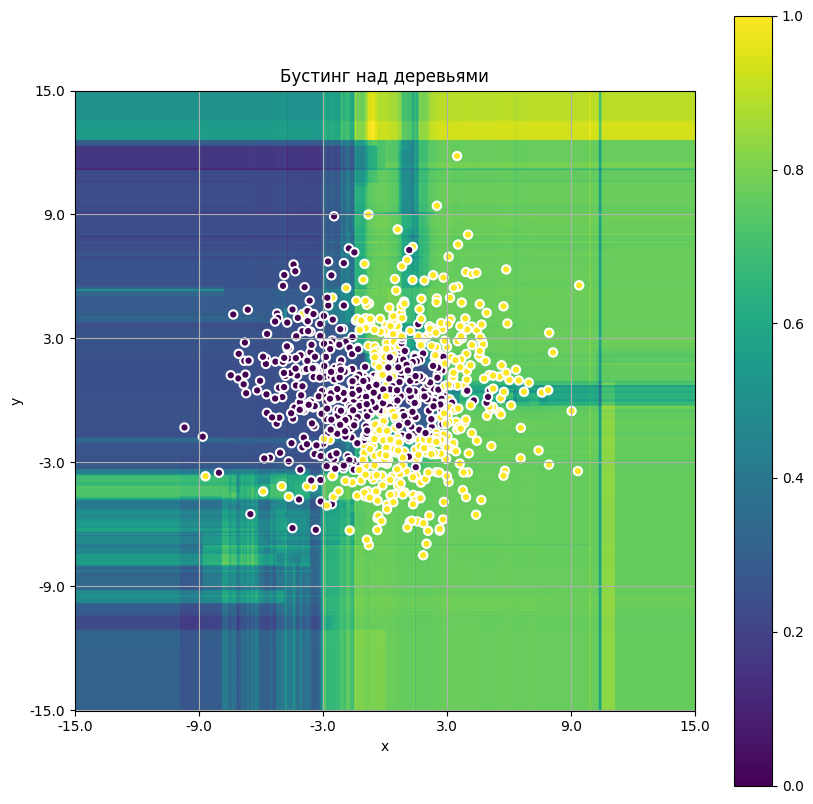

In [43]:
plot_predicts(
    model=boosting_dec_tree_5, features=X_train_synthetic, targets=y_train_synthetic,
    x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0], title='Бустинг над деревьями', mode='classification')

____

In [624]:
%%time
# Бустинг над случайным лесом
boosting_rfg = Boosting(
    base_model_class=RandomForestRegressor,
    base_model_params={'n_estimators': 50, 'max_depth': 100},
    n_estimators=100,
    learning_rate=0.5,
    subsample=1,
    random_seed=228,
    custom_loss=None,
    use_best_model=True,
    n_iter_early_stopping=5,
    show_process=True
)
boosting_rfg.fit(X_testing_train, y_testing_train, eval_set=(X_testing_val, y_testing_val))
preds_rfg = boosting_rfg.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_rfg)))

0: train_loss = 0.5336249088233106 _ val_loss = 0.5163120347739325
1: train_loss = 0.49130068511530445 _ val_loss = 0.4982496924415035
2: train_loss = 0.4664494148524104 _ val_loss = 0.48615834725830964
3: train_loss = 0.45068841449730795 _ val_loss = 0.477283727292666
4: train_loss = 0.44006690946732935 _ val_loss = 0.47038030409162973
5: train_loss = 0.43252481531931486 _ val_loss = 0.46476677966510954
6: train_loss = 0.42693058818929247 _ val_loss = 0.46006429451253816
7: train_loss = 0.4226165160603409 _ val_loss = 0.45603729386608205
8: train_loss = 0.4191773494524813 _ val_loss = 0.4525350255839087
9: train_loss = 0.4163590933180594 _ val_loss = 0.4494525292371923
10: train_loss = 0.4139956425104046 _ val_loss = 0.4467160170253243
11: train_loss = 0.41197371404860317 _ val_loss = 0.44426581986762786
12: train_loss = 0.41021612203560354 _ val_loss = 0.44205834289615353
13: train_loss = 0.4086683614074725 _ val_loss = 0.4400589671690435
14: train_loss = 0.407290667600901 _ val_loss

In [47]:
%%time
# Бустинг над случайным лесом синтетика с графиком
boosting_rfg = Boosting(
    base_model_class=RandomForestRegressor,
    base_model_params={'n_estimators': 20, 'max_depth': 20},
    n_estimators=27,
    learning_rate=1,
    subsample=1,
    random_seed=228,
    custom_loss=None,
    use_best_model=True,
    n_iter_early_stopping=5,
    show_process=True
)
boosting_rfg.fit(X_train_synthetic, y_train_synthetic)
preds_rfg = np.round(boosting_rfg.predict(X_test_synthetic) > 0.5)
print('Accuracy: ', accuracy_score((y_test_synthetic == 1), np.round(preds_rfg)))

0: train_loss = 0.6027125426454141
1: train_loss = 0.592725085907606
2: train_loss = 0.5844949555127473
3: train_loss = 0.5777487090701496
4: train_loss = 0.5722234156990861
5: train_loss = 0.5677025803673971
6: train_loss = 0.5639956021887256
7: train_loss = 0.5609415572348828
8: train_loss = 0.5584263352750262
9: train_loss = 0.5563248241339173
10: train_loss = 0.5545712465011101
11: train_loss = 0.5530987182258018
12: train_loss = 0.551852571907519
13: train_loss = 0.5507955859203103
14: train_loss = 0.549898534925763
15: train_loss = 0.5491412183148348
16: train_loss = 0.5484943920223038
17: train_loss = 0.5479427576171733
18: train_loss = 0.5474778055686909
19: train_loss = 0.5470901634237788
20: train_loss = 0.5467671841155359
21: train_loss = 0.5465017701712819
22: train_loss = 0.5462867640824319
23: train_loss = 0.5461196191052963
24: train_loss = 0.5459922867091418
25: train_loss = 0.5459022233707315
26: train_loss = 0.5458449637186065
Accuracy:  0.90245
CPU times: user 2min 6

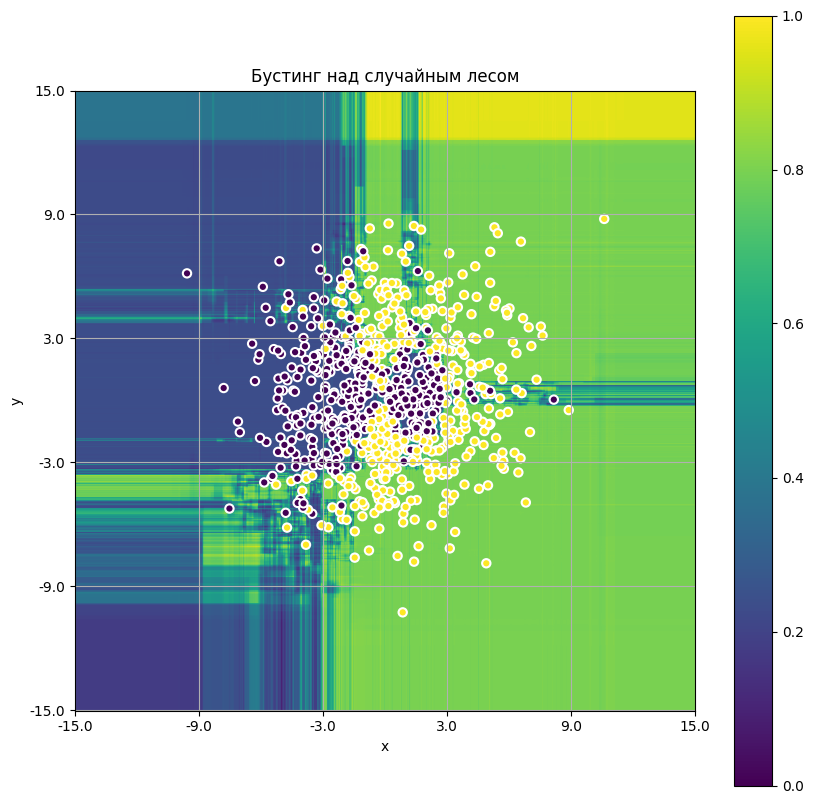

In [48]:
plot_predicts(
    model=boosting_rfg, features=X_train_synthetic, targets=y_train_synthetic,
    x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0], title='Бустинг над случайным лесом', mode='classification')

____

In [634]:
%%time
# Бустинг над линейной регрессией
boosting_linreg = Boosting(
    base_model_class=LinearRegression,
    base_model_params={},
    n_estimators=10000,
    learning_rate=0.5,
    subsample=1,
    random_seed=228,
    custom_loss=None,
    use_best_model=True,
    n_iter_early_stopping=20,
    show_process=False
)
boosting_linreg.fit(X_testing_train, y_testing_train, eval_set=(X_testing_val, y_testing_val))
preds_linreg = boosting_linreg.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_linreg)))

Accuracy:  0.65
CPU times: user 913 ms, sys: 478 ms, total: 1.39 s
Wall time: 268 ms


In [50]:
%%time
# Бустинг над линейной регрессией синтетика с графиком
boosting_linreg = Boosting(
    base_model_class=LinearRegression,
    base_model_params={},
    n_estimators=1000,
    learning_rate=0.5,
    subsample=1,
    random_seed=228,
    custom_loss=None,
    use_best_model=True,
    n_iter_early_stopping=20,
    show_process=False
)
boosting_linreg.fit(X_train_synthetic, y_train_synthetic)
preds_linreg = np.round(boosting_linreg.predict(X_test_synthetic) > 0.5)
print('Accuracy: ', accuracy_score((y_test_synthetic == 1), np.round(preds_linreg)))

Accuracy:  0.5555
CPU times: user 2min 42s, sys: 1min 21s, total: 4min 3s
Wall time: 42.9 s


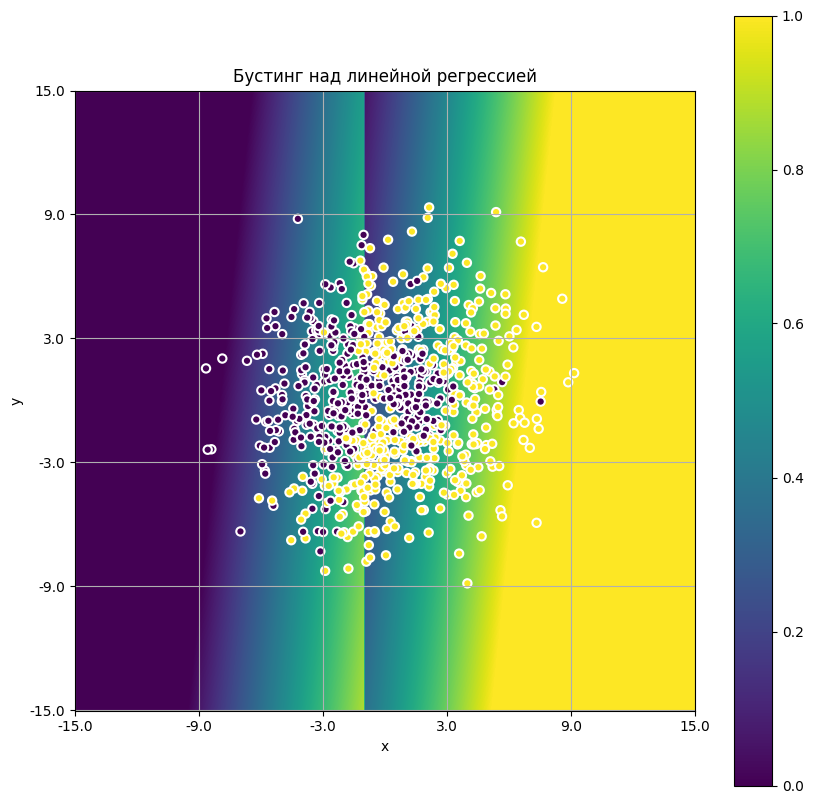

In [51]:
plot_predicts(
    model=boosting_linreg, features=X_train_synthetic, targets=y_train_synthetic,
    x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0], title='Бустинг над линейной регрессией', mode='classification')

____

In [21]:
log_reg = LogisticRegression(
    penalty='l2',
    solver='liblinear'
)
log_reg.fit(X_testing_train, y_testing_train)
preds_log_reg = log_reg.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_log_reg)))

Accuracy:  0.422


In [53]:
log_reg = LogisticRegression(
    penalty='l2',
    solver='liblinear'
)
log_reg.fit(X_train_synthetic, y_train_synthetic)
preds_log_reg = log_reg.predict(X_test_synthetic)
print('Accuracy: ', accuracy_score((y_test_synthetic == 1), np.round(preds_log_reg)))

Accuracy:  0.3483


#### 3. (2 балла) Мы разобрались с бустингом, теперь интересно посмотреть на совсем дикие комбинации моделей. Сравните результаты следующих моделей на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Используйте логистическую регрессию, случайный лес и BaggingClassifier из sklearn.

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (`max_features` около 0.6 в BaggingClassifier)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

__Коммент:__ Очень долго обучаются модели на датасете синтетическом, поэтому использовал здесь только реальный (банк дата).

1) Какая из моделей имеет лучшее качество? С чем это связано?
   
   __Ответ:__ Все модели имеют примерно похожее качество, так как везде использовался бэггинг над деревьями или бустинга над деревьями, за исключением логистической регрессии. Accuracy около 0.45

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка?
   
   __Ответ:__  Быстрее всего переобучилась модель - бэггинг над лог регрессиями, а сильнее всего переобучаться здесь может бэггинг над деревьями, у которых не задана максимальная глубина, так как они могут подстроиться под всю выборку. Раннюю остановку не использовал.

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?
   
   __Ответ:__  Бустинг с большим числом эстимейторов не показал переобучения, так как бэггинг усреднил предсказания всех базовых моделей. Стабильное качество на любом кол-ве бустингов в бэггинге.

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?
   
   __Ответ:__  Случайны лес показал себя более стабильным, при устремлеении кол-ва эстимейторов в бесконечность - качество прыгает на том же уровне.

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?
   
   __Ответ:__  Бустинг показывает себя лучше, чем бэггинг в наших экспериментах, так как он уменьшает смещение, за счет чего лучше находит зависимости в данных, чем бустинг + работает за более адекватное время при оптимальных гиперпараметрах. Главный нюанс бустинга в наше эксперименте, что он быстрее переобучается, но при наличии ранней остановки - все намного лучше, чем в бэггинге. При неглубоких деревьях - бустинг работает достаточно быстро и хорошо находит зависимости в данных.

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

In [91]:
# Случайный лес
# 1
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100)
rf_model.fit(X_testing_train, y_testing_train)
preds_rf_model = rf_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_rf_model)))

Accuracy:  0.448


In [92]:
# 2
rf_model = RandomForestClassifier(n_estimators=300, max_depth=100)
rf_model.fit(X_testing_train, y_testing_train)
preds_rf_model = rf_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_rf_model)))

Accuracy:  0.452


In [93]:
# 3
rf_model = RandomForestClassifier(n_estimators=500, max_depth=100)
rf_model.fit(X_testing_train, y_testing_train)
preds_rf_model = rf_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_rf_model)))

Accuracy:  0.45


In [94]:
# 4
rf_model = RandomForestClassifier(n_estimators=800, max_depth=100)
rf_model.fit(X_testing_train, y_testing_train)
preds_rf_model = rf_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_rf_model)))

Accuracy:  0.452


____

In [86]:
# Бэггинг на деревьях
# 1
bagging_tree_leaf_model = BaggingClassifier(
    n_estimators=100,
    estimator=DecisionTreeClassifier(min_samples_leaf=1),
    random_state=228
)
bagging_tree_leaf_model.fit(X_testing_train, y_testing_train)
preds_bagging_tree_leaf_model = bagging_tree_leaf_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_tree_leaf_model)))

Accuracy:  0.442


In [87]:
# 2
bagging_tree_leaf_model = BaggingClassifier(
    n_estimators=300,
    estimator=DecisionTreeClassifier(min_samples_leaf=1),
    random_state=228
)
bagging_tree_leaf_model.fit(X_testing_train, y_testing_train)
preds_bagging_tree_leaf_model = bagging_tree_leaf_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_tree_leaf_model)))

Accuracy:  0.45


In [88]:
# 3
bagging_tree_leaf_model = BaggingClassifier(
    n_estimators=500,
    estimator=DecisionTreeClassifier(min_samples_leaf=1),
    random_state=228
)
bagging_tree_leaf_model.fit(X_testing_train, y_testing_train)
preds_bagging_tree_leaf_model = bagging_tree_leaf_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_tree_leaf_model)))

Accuracy:  0.452


In [90]:
# 4
bagging_tree_leaf_model = BaggingClassifier(
    n_estimators=800,
    estimator=DecisionTreeClassifier(min_samples_leaf=1),
    random_state=228
)
bagging_tree_leaf_model.fit(X_testing_train, y_testing_train)
preds_bagging_tree_leaf_model = bagging_tree_leaf_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_tree_leaf_model)))

Accuracy:  0.45


____

In [82]:
# Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков
# 1
bagging_tree_max_feat = BaggingClassifier(
    n_estimators=100,
    estimator=DecisionTreeClassifier(max_features=0.6),
    random_state=228
)
bagging_tree_max_feat.fit(X_testing_train, y_testing_train)
preds_bagging_tree_max_feat = bagging_tree_max_feat.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_tree_max_feat)))

Accuracy:  0.45


In [83]:
# 2
bagging_tree_max_feat = BaggingClassifier(
    n_estimators=300,
    estimator=DecisionTreeClassifier(max_features=0.6),
    random_state=228
)
bagging_tree_max_feat.fit(X_testing_train, y_testing_train)
preds_bagging_tree_max_feat = bagging_tree_max_feat.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_tree_max_feat)))

Accuracy:  0.452


In [84]:
# 3
bagging_tree_max_feat = BaggingClassifier(
    n_estimators=500,
    estimator=DecisionTreeClassifier(max_features=0.6),
    random_state=228
)
bagging_tree_max_feat.fit(X_testing_train, y_testing_train)
preds_bagging_tree_max_feat = bagging_tree_max_feat.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_tree_max_feat)))

Accuracy:  0.45


In [85]:
# 4
bagging_tree_max_feat = BaggingClassifier(
    n_estimators=800,
    estimator=DecisionTreeClassifier(max_features=0.6),
    random_state=228
)
bagging_tree_max_feat.fit(X_testing_train, y_testing_train)
preds_bagging_tree_max_feat = bagging_tree_max_feat.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_tree_max_feat)))

Accuracy:  0.45


____

In [95]:
# На самописном классе возникает ошибка
bagging_tree_max_feat = BaggingClassifier(
    n_estimators=100,
    estimator=Boosting(
        base_model_class=DecisionTreeRegressor,
        base_model_params={'max_depth': 5},
        n_estimators=110,
        learning_rate=0.1,
        subsample=1,
        random_seed=228,
        custom_loss=None,
        use_best_model=True,
        n_iter_early_stopping=10,
        show_process=False
    ),
    random_state=228
)

TypeError: Cannot clone object '<__main__.Boosting object at 0x132879c70>' (type <class '__main__.Boosting'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [97]:
# Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
# 1
bagging_boost = BaggingClassifier(
    n_estimators=100,
    estimator=GradientBoostingClassifier(n_estimators=150),
    random_state=228
)
bagging_boost.fit(X_testing_train, y_testing_train)
preds_bagging_boost = bagging_boost.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_boost)))

Accuracy:  0.448


In [98]:
# 2
bagging_boost = BaggingClassifier(
    n_estimators=300,
    estimator=GradientBoostingClassifier(n_estimators=150),
    random_state=228
)
bagging_boost.fit(X_testing_train, y_testing_train)
preds_bagging_boost = bagging_boost.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_boost)))

Accuracy:  0.448


In [99]:
# 3
bagging_boost = BaggingClassifier(
    n_estimators=500,
    estimator=GradientBoostingClassifier(n_estimators=150),
    random_state=228
)
bagging_boost.fit(X_testing_train, y_testing_train)
preds_bagging_boost = bagging_boost.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_boost)))

Accuracy:  0.448


In [100]:
# 4
bagging_boost = BaggingClassifier(
    n_estimators=800,
    estimator=GradientBoostingClassifier(n_estimators=150),
    random_state=228
)
bagging_boost.fit(X_testing_train, y_testing_train)
preds_bagging_boost = bagging_boost.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_boost)))

Accuracy:  0.448


____

In [112]:
# Бэггинг на логистических регрессиях
# 1
bagging_logist = BaggingClassifier(
    n_estimators=100,
    estimator=LogisticRegression(max_iter=3000),
    random_state=228
)
bagging_logist.fit(X_testing_train, y_testing_train)
preds_bagging_logist = bagging_logist.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_logist)))

/Users/dsbulg10/Desktop/study/ml_study_hws/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy:  0.426


In [113]:
# 2
bagging_logist = BaggingClassifier(
    n_estimators=300,
    estimator=LogisticRegression(max_iter=3000),
    random_state=228
)
bagging_logist.fit(X_testing_train, y_testing_train)
preds_bagging_logist = bagging_logist.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_logist)))

/Users/dsbulg10/Desktop/study/ml_study_hws/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/dsbulg10/Desktop/study/ml_study_hws/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Accuracy:  0.424


In [111]:
# 3
bagging_logist = BaggingClassifier(
    n_estimators=500,
    estimator=LogisticRegression(max_iter=3000),
    random_state=228
)
bagging_logist.fit(X_testing_train, y_testing_train)
preds_bagging_logist = bagging_logist.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_logist)))

/Users/dsbulg10/Desktop/study/ml_study_hws/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/dsbulg10/Desktop/study/ml_study_hws/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Accuracy:  0.424


In [114]:
# 4
bagging_logist = BaggingClassifier(
    n_estimators=800,
    estimator=LogisticRegression(max_iter=3000),
    random_state=228
)
bagging_logist.fit(X_testing_train, y_testing_train)
preds_bagging_logist = bagging_logist.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_bagging_logist)))

/Users/dsbulg10/Desktop/study/ml_study_hws/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/dsbulg10/Desktop/study/ml_study_hws/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Accuracy:  0.424


#### 4. (2 балла) Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией. Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов. Получилось ли у вас победить библиотечные реализации на тестовых данных? 

__Ответ:__  
Эмпирическим путем подобрал гиперпараметры, перебор по сетке - долгий...  
Самописный с такими параметрами обогнал по accuracy реализацию xgboost, но уверен, что можно подобрть гиперпараметры, которые выведут xgboost далеко вперед. Попробую это сделать, но сейчас уже ддл:)

In [6]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

In [117]:
from catboost import CatBoostClassifier

In [123]:
# из коробки
cbm_model = CatBoostClassifier(
    verbose=False
)
cbm_model.fit(X_testing_train, y_testing_train)
preds_cbm_model = cbm_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_cbm_model)))

Accuracy:  0.446


In [163]:
%%time
# подобрал некоторые параметры
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    random_state=228,
    early_stopping_rounds=0
)
xgb_model.fit(X_testing_train, (y_testing_train == 1))
preds_xgb_model = xgb_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score((y_testing_test == 1), (preds_xgb_model).astype(np.bool_)))

Accuracy:  0.884
CPU times: user 13.9 s, sys: 1.1 s, total: 15 s
Wall time: 1.6 s


In [131]:
%%time
# Самописный
selfmade_model = Boosting(
    base_model_class=DecisionTreeRegressor,
    base_model_params={'max_depth': 5},
    n_estimators=1000,
    learning_rate=0.1,
    subsample=1,
    random_seed=228,
    custom_loss=None,
    use_best_model=True,
    n_iter_early_stopping=20,
    show_process=False
)
selfmade_model.fit(X_testing_train, y_testing_train,)
preds_selfmade_model = selfmade_model.predict(X_testing_test)
print('Accuracy: ', accuracy_score(y_testing_test, np.round(preds_selfmade_model)))

Accuracy:  0.888
CPU times: user 896 ms, sys: 15.7 ms, total: 912 ms
Wall time: 912 ms
